# Testing the Compressor

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from lossycomp.compress import compress
from lossycomp.decompress import decompress
from lossycomp.plots import single_plot

## Reading Data

In [2]:
data_or = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1979-01-14T16:00:00','1979-01-15T07:00:00'),level = slice(978,1000), longitude=slice(-180,180), latitude=slice(90,-90))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')
data_or = data_or['t'].values
data_or.shape

(16, 721, 1440, 1)

## Compress

In [3]:
compressed_data, num_chunks = compress(data_or)

Data shape: (16, 721, 1440, 1)
Chunks shape: (450, 16, 48, 48, 1)
Compression factor: 102.54222222222222


In [4]:
decompressed_data = decompress(compressed_data, num_chunks)

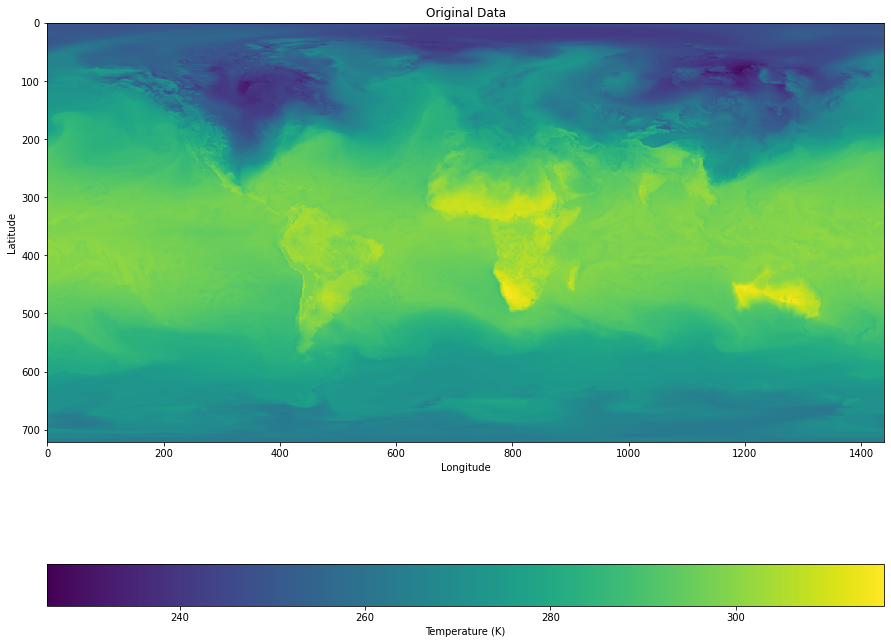

In [5]:
data_r = np.expand_dims(data_or, axis=0)
single_plot(data_r, 0, "Original Data", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())

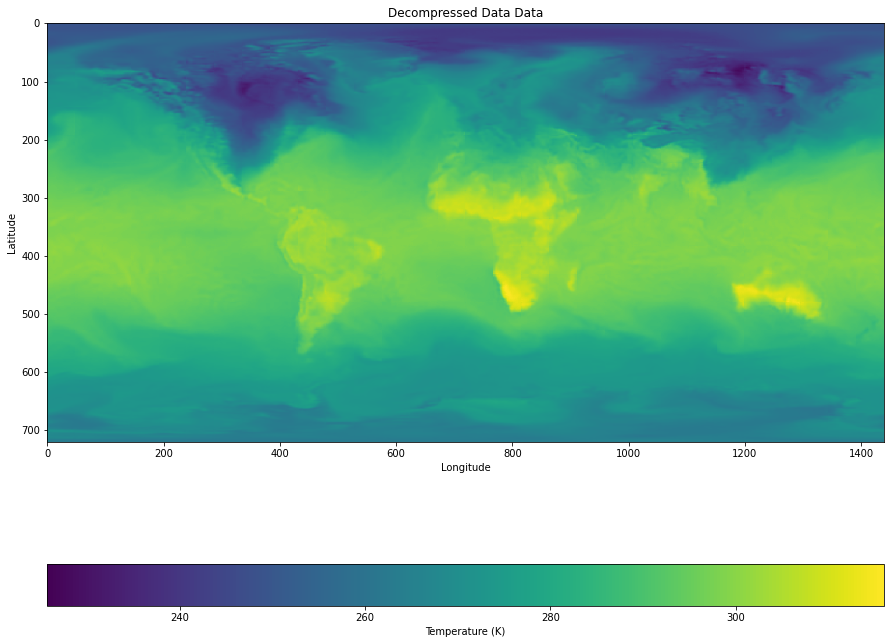

In [6]:
decom = np.expand_dims(decompressed_data, axis=0)
single_plot(decom, 0, "Decompressed Data Data", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())

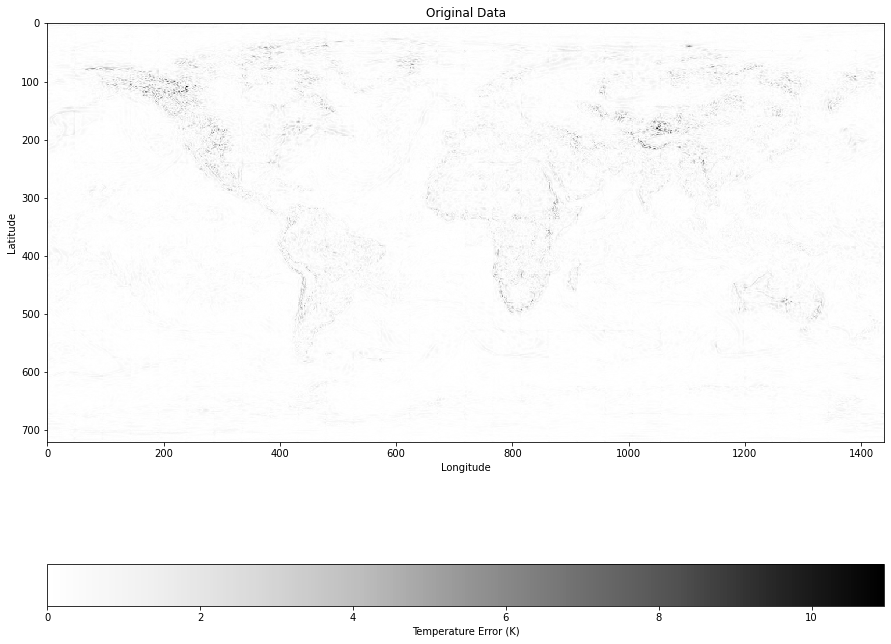

In [7]:
diff = abs(data_r[:,:,0:720,:,:]-decom)
single_plot(diff, 0, "Original Data", "Temperature Error (K)", diff[0,0].min(), diff[0,0].max(), 'Greys')

## Some statistics


Data Original
Mean: 278.9894
Variance: 302.65555
Max Val: 319.0653
Min Val: 222.65034

Decompressed
Mean: 278.9835
Variance: 302.51617
Max Val: 318.91437
Min Val: 225.64537

Error
Mean: 0.24869679
Variance: 0.13886522
Max error: 10.948502
Min error: 0.0



Text(0, 0.5, 'Count')

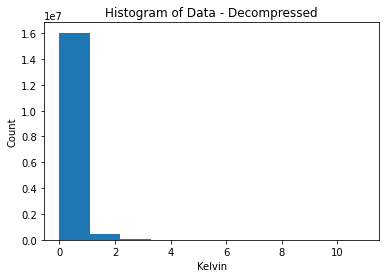

In [8]:
original = data_r[:,:,0:720,:,:]

print("")
print("Data Original")
print("=======")
print("Mean:", original.mean())
print("Variance:", original.var())
print("Max Val:", original.max())
print("Min Val:", original.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", decom.mean())
print("Variance:", decom.var())
print("Max Val:", decom.max())
print("Min Val:", decom.min())
print("")
print("Error")
print("=======")
print("Mean:", diff.mean())
print("Variance:", diff.var())
print("Max error:", diff.max())
print("Min error:", diff.min())
print("")

plt.hist(diff.flatten())
plt.title('Histogram of Data - Decompressed')
plt.xlabel('Kelvin')
plt.ylabel('Count')